## Imports

In [11]:
pip install darts

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install u8darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.0/694.0 kB 18.7 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [13]:
import copy
from pathlib import Path
import warnings
import holidays
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import random
import gc

## Importing Subject Data
From the vital sign dataset - the subject with the most rows of available data was selected, exported and loaded here

In [14]:

vital_signs_df = pd.read_csv("/kaggle/input/triage/15496609.csv")
vital_signs_df.drop(columns=['index', 'subject_id', 'stay_id'], inplace=True)
vital_signs_df

,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
0,2159-01-26 19:07:00,97.7,83.0,16.0,96.0,106.0,69.0
1,2159-01-26 22:40:00,97.7,99.0,16.0,97.0,125.0,77.0
2,2159-01-27 06:08:00,99.1,120.0,17.0,96.0,176.0,101.0
3,2159-01-27 06:26:00,99.1,99.0,17.0,96.0,176.0,101.0
4,2159-01-27 06:43:00,99.1,93.0,19.0,100.0,136.0,83.0
...,...,...,...,...,...,...,...
1087,2165-07-24 07:50:00,98.8,85.0,16.0,99.0,160.0,81.0
1088,2165-07-24 14:23:00,98.2,102.0,17.0,95.0,109.0,67.0
1089,2165-08-02 19:08:00,97.2,112.0,16.0,95.0,103.0,45.0
1090,2165-08-07 14:05:00,96.6,91.0,17.0,98.0,158.0,99.0


In [15]:
vital_signs_df['charttime'] = pd.to_datetime(vital_signs_df['charttime'])
vital_signs_df.dtypes

charttime      datetime64[ns]
temperature           float64
heartrate             float64
resprate              float64
o2sat                 float64
sbp                   float64
dbp                   float64
dtype: object

Since the all the data has been offsetted by a random amount for deidentification where all the dates were between 2159 and 2165, therefore i modified the offset by -145 years as a guess so the dates dont look too wierd 😅 The new charttimes are between 2014 to 2020

In [16]:
# Define the offset to shift the dates by
offset = pd.DateOffset(years=145)

# Subtract the offset from the dates in the charttime column
vital_signs_df['charttime'] = vital_signs_df['charttime'] - offset

In [17]:
vital_signs_df

,charttime,temperature,heartrate,resprate,o2sat,sbp,dbp
0,2014-01-26 19:07:00,97.7,83.0,16.0,96.0,106.0,69.0
1,2014-01-26 22:40:00,97.7,99.0,16.0,97.0,125.0,77.0
2,2014-01-27 06:08:00,99.1,120.0,17.0,96.0,176.0,101.0
3,2014-01-27 06:26:00,99.1,99.0,17.0,96.0,176.0,101.0
4,2014-01-27 06:43:00,99.1,93.0,19.0,100.0,136.0,83.0
...,...,...,...,...,...,...,...
1087,2020-07-24 07:50:00,98.8,85.0,16.0,99.0,160.0,81.0
1088,2020-07-24 14:23:00,98.2,102.0,17.0,95.0,109.0,67.0
1089,2020-08-02 19:08:00,97.2,112.0,16.0,95.0,103.0,45.0
1090,2020-08-07 14:05:00,96.6,91.0,17.0,98.0,158.0,99.0


In [18]:
# Set the 'charttime' column as the index
vital_signs_df.set_index('charttime', inplace=True)

In [19]:
vitaldf  = vital_signs_df
# Resample the data to a daily frequency
vitaldf = vitaldf.resample('D').mean()
vitaldf

,temperature,heartrate,resprate,o2sat,sbp,dbp
charttime,,,,,,
2014-01-26,97.700,91.00,16.00,96.50,115.5,73.00
2014-01-27,98.775,102.75,17.25,97.75,169.0,96.75
2014-01-28,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-29,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-30,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-08-03,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-04,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-05,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Interpolate the missing values
vitaldf = vitaldf.interpolate()
vitaldf

,temperature,heartrate,resprate,o2sat,sbp,dbp
charttime,,,,,,
2014-01-26,97.700000,91.000000,16.000000,96.50,115.500000,73.00
2014-01-27,98.775000,102.750000,17.250000,97.75,169.000000,96.75
2014-01-28,98.663333,101.433333,17.433333,97.70,160.066667,91.80
2014-01-29,98.551667,100.116667,17.616667,97.65,151.133333,86.85
2014-01-30,98.440000,98.800000,17.800000,97.60,142.200000,81.90
...,...,...,...,...,...,...
2020-08-03,97.080000,106.600000,16.200000,95.60,112.100000,54.90
2020-08-04,96.960000,101.200000,16.400000,96.20,121.200000,64.80
2020-08-05,96.840000,95.800000,16.600000,96.80,130.300000,74.70


In [21]:
cols_to_round = ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
vitaldf[cols_to_round] = vitaldf[cols_to_round].round(2)

In [22]:
vitaldf

,temperature,heartrate,resprate,o2sat,sbp,dbp
charttime,,,,,,
2014-01-26,97.70,91.00,16.00,96.50,115.50,73.00
2014-01-27,98.78,102.75,17.25,97.75,169.00,96.75
2014-01-28,98.66,101.43,17.43,97.70,160.07,91.80
2014-01-29,98.55,100.12,17.62,97.65,151.13,86.85
2014-01-30,98.44,98.80,17.80,97.60,142.20,81.90
...,...,...,...,...,...,...
2020-08-03,97.08,106.60,16.20,95.60,112.10,54.90
2020-08-04,96.96,101.20,16.40,96.20,121.20,64.80
2020-08-05,96.84,95.80,16.60,96.80,130.30,74.70


<AxesSubplot:xlabel='charttime'>

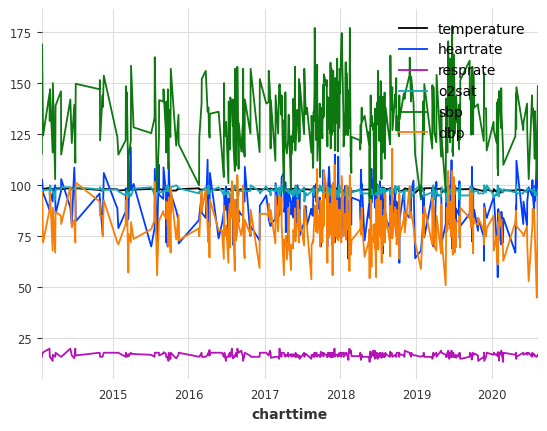

In [23]:
vitaldf.plot()

In [24]:
from darts import TimeSeries
train_series = TimeSeries.from_dataframe(vitaldf)
train_series

<TimeSeries (DataArray) (charttime: 2386, component: 6, sample: 1)>
array([[[ 97.7 ],
        [ 91.  ],
        [ 16.  ],
        [ 96.5 ],
        [115.5 ],
        [ 73.  ]],

       [[ 98.78],
        [102.75],
        [ 17.25],
        [ 97.75],
        [169.  ],
        [ 96.75]],

       [[ 98.66],
        [101.43],
        [ 17.43],
        [ 97.7 ],
        [160.07],
        [ 91.8 ]],
...
       [[ 96.84],
        [ 95.8 ],
        [ 16.6 ],
        [ 96.8 ],
        [130.3 ],
        [ 74.7 ]],

       [[ 96.72],
        [ 90.4 ],
        [ 16.8 ],
        [ 97.4 ],
        [139.4 ],
        [ 84.6 ]],

       [[ 96.6 ],
        [ 85.  ],
        [ 17.  ],
        [ 98.  ],
        [148.5 ],
        [ 94.5 ]]])
Coordinates:
  * charttime  (charttime) datetime64[ns] 2014-01-26 2014-01-27 ... 2020-08-07
  * component  (component) object 'temperature' 'heartrate' ... 'sbp' 'dbp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Normalize the dataset values
Making it easier for the model to learn it.

In [25]:
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler

scaler = Scaler(MinMaxScaler(feature_range=(-1, 1)))
transformer = scaler.fit(train_series)

In [26]:
import joblib

# Dump the model to a file
joblib.dump(scaler, 'forecast_scaler.joblib')

['forecast_scaler.joblib']

In [27]:
series_transformed = transformer.transform(train_series)
series_transformed

<TimeSeries (DataArray) (charttime: 2386, component: 6, sample: 1)>
array([[[ 0.03030303],
        [ 0.13385827],
        [-0.23076923],
        [ 0.125     ],
        [-0.44927536],
        [-0.23287671]],

       [[ 0.68484848],
        [ 0.50393701],
        [ 0.15384615],
        [ 0.4375    ],
        [ 0.79130435],
        [ 0.41780822]],

       [[ 0.61212121],
        [ 0.4623622 ],
        [ 0.20923077],
        [ 0.425     ],
        [ 0.58423188],
        [ 0.28219178]],
...
       [[-0.49090909],
        [ 0.28503937],
        [-0.04615385],
        [ 0.2       ],
        [-0.10608696],
        [-0.18630137]],

       [[-0.56363636],
        [ 0.11496063],
        [ 0.01538462],
        [ 0.35      ],
        [ 0.10492754],
        [ 0.08493151]],

       [[-0.63636364],
        [-0.05511811],
        [ 0.07692308],
        [ 0.5       ],
        [ 0.31594203],
        [ 0.35616438]]])
Coordinates:
  * charttime  (charttime) datetime64[ns] 2014-01-26 2014-01-27 ... 2020-08-07
  * component  (component) object 'temperature' 'heartrate' ... 'sbp' 'dbp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Split the data into a training set and a test set

In [28]:
train_size = int(len(series_transformed) * 0.8)
train_data = series_transformed[:train_size]
test_data = series_transformed[train_size:]

In [29]:
from darts import TimeSeries
from darts.models import XGBModel

In [30]:
from darts.metrics import mape, mae, rmse,mase

In [31]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop = EarlyStopping(patience=10, monitor='train_loss')

pl_trainer_kwargs={"callbacks": [early_stop]}

## Creating the Model

In [32]:
## Fitting models and checking the performance
def eval_model(model):
    model.fit(train_data)
    forecast = model.predict(len(test_data))
    print('model {} obtains MAE: {:.2f}%'.format(model, mae(test_data, forecast)))
    print('model {} obtains RMSE: {:.2f}%'.format(model, rmse(test_data, forecast)))
    return model,forecast

In [33]:
m_xgb, f_xgb = eval_model(XGBModel(lags=1,n_estimators=2000, max_depth=5))

model MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
  

In [34]:
train_data_orig = transformer.inverse_transform(train_data)
test_data_orig = transformer.inverse_transform(test_data)
f_xgb_orig = transformer.inverse_transform(f_xgb)
f_xgb_orig

<TimeSeries (DataArray) (charttime: 478, component: 6, sample: 1)>
array([[[ 98.19896 ],
        [ 95.57534 ],
        [ 17.411036],
        [ 95.50203 ],
        [134.27872 ],
        [ 74.56111 ]],

       [[ 98.398926],
        [ 95.49859 ],
        [ 17.772966],
        [ 94.42766 ],
        [132.23434 ],
        [ 74.594315]],

       [[ 98.6111  ],
        [ 99.927734],
        [ 17.859459],
        [ 94.83289 ],
        [126.788994],
        [ 72.332146]],
...
       [[ 97.70268 ],
        [ 90.42149 ],
        [ 14.637982],
        [ 97.64999 ],
        [124.04657 ],
        [ 74.60017 ]],

       [[ 97.82141 ],
        [ 90.9076  ],
        [ 14.195247],
        [ 96.94209 ],
        [126.71592 ],
        [ 71.903336]],

       [[ 97.89901 ],
        [ 98.07838 ],
        [ 14.407938],
        [ 96.744644],
        [122.93027 ],
        [ 72.72725 ]]], dtype=float32)
Coordinates:
  * charttime  (charttime) datetime64[ns] 2019-04-18 2019-04-19 ... 2020-08-07
  * component  (component) object 'temperature' 'heartrate' ... 'sbp' 'dbp'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

## Visualising the Forecasting Results

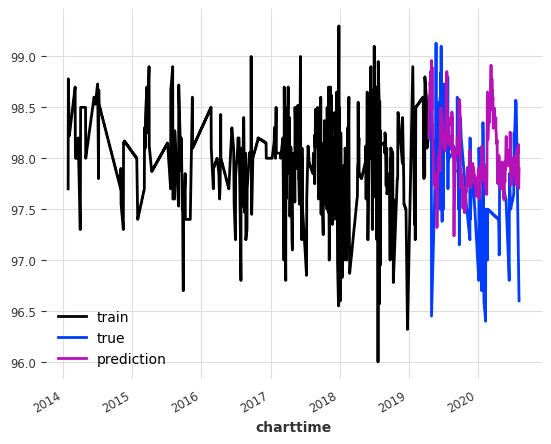

In [35]:
## Visualizing XGBoost forecasting result
train_data_orig['temperature'].plot(label='train')
test_data_orig['temperature'].plot(label='true')
f_xgb_orig['temperature'].plot(label='prediction')
plt.legend();

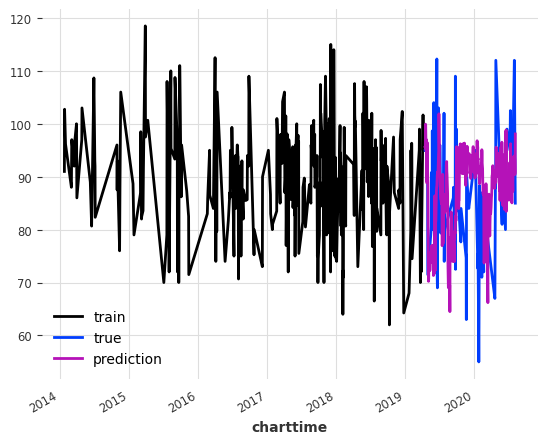

In [36]:
train_data_orig['heartrate'].plot(label='train')
test_data_orig['heartrate'].plot(label='true')
f_xgb_orig['heartrate'].plot(label='prediction')
plt.legend();

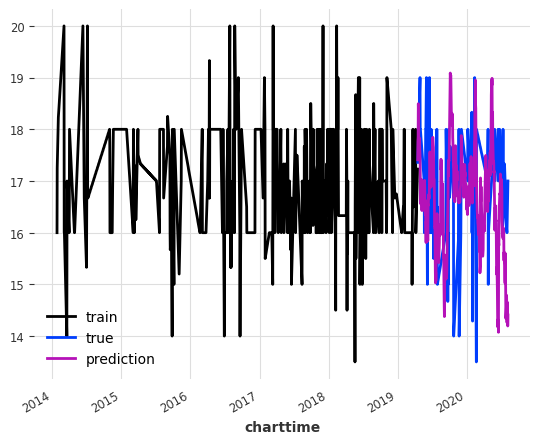

In [37]:
train_data_orig['resprate'].plot(label='train')
test_data_orig['resprate'].plot(label='true')
f_xgb_orig['resprate'].plot(label='prediction')
plt.legend();

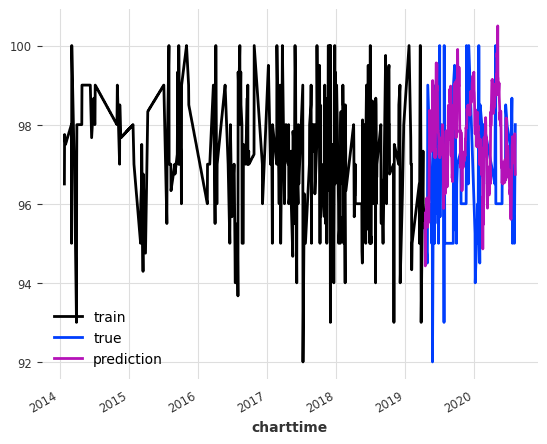

In [38]:
train_data_orig['o2sat'].plot(label='train')
test_data_orig['o2sat'].plot(label='true')
f_xgb_orig['o2sat'].plot(label='prediction')
plt.legend();

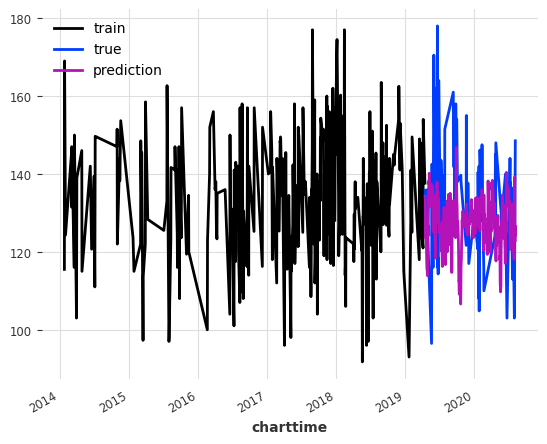

In [39]:
train_data_orig['sbp'].plot(label='train')
test_data_orig['sbp'].plot(label='true')
f_xgb_orig['sbp'].plot(label='prediction')
plt.legend();

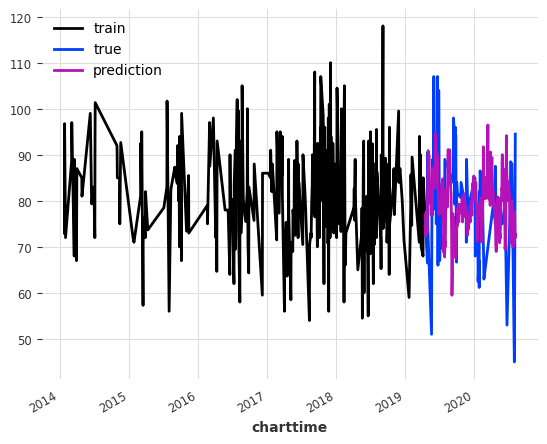

In [40]:
train_data_orig['dbp'].plot(label='train')
test_data_orig['dbp'].plot(label='true')
f_xgb_orig['dbp'].plot(label='prediction')
plt.legend();

## Saving the Model using Joblib library

In [41]:
import joblib    

In [42]:
# save to JSON
m_xgb.save("xgb_forecasting.json")

---

# Loading the saved model

make sure you do a - pip install darts - before loading the model

In [45]:
from darts.models import XGBModel

# save to JSON
forecasting_model = XGBModel.load("xgb_forecasting.json")

### Preparing the Input Data

In [46]:
# Example Input - Would be multiple rows of data where each row would technically be the vitals of a day

data = [
 [ 98.6,   70. ,  16. ,  98. , 120. ,  80. ],
 [ 98.2,  68. ,  18. ,  96. , 122. ,  78. ],
 [ 98.4,  72. ,  20. ,  95. , 118. ,  82. ],
 [ 98.8,  75. ,  18. ,  97. , 125. ,  80. ],
 [ 99. ,  80. ,  22. ,  94. , 130. ,  85. ],
 [ 99.2,  82. ,  24. ,  92. , 128. ,  84. ],
 [ 99.5,  85. ,  26. ,  90. , 130. ,  82. ]]

# Prepare the input data
data = np.array(data)  # Convert the data to a numpy array
data

array([[ 98.6,  70. ,  16. ,  98. , 120. ,  80. ],
       [ 98.2,  68. ,  18. ,  96. , 122. ,  78. ],
       [ 98.4,  72. ,  20. ,  95. , 118. ,  82. ],
       [ 98.8,  75. ,  18. ,  97. , 125. ,  80. ],
       [ 99. ,  80. ,  22. ,  94. , 130. ,  85. ],
       [ 99.2,  82. ,  24. ,  92. , 128. ,  84. ],
       [ 99.5,  85. ,  26. ,  90. , 130. ,  82. ]])

In [47]:
from darts import TimeSeries
input_data = TimeSeries.from_values(data)

### Normalizing the data for the model

In [48]:
# Load the model joblib
forecasting_scaler = joblib.load('forecast_scaler.joblib')

In [49]:
normalized_data = forecasting_scaler.transform(input_data)

In [50]:
forecasting_model.fit(normalized_data)

XGBModel(lags=1, lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, n_estimators=2000, max_depth=5)

In [51]:
forecast = forecasting_model.predict(1) # Requesting one row prediction
forecast = transformer.inverse_transform(forecast)
forecast

<TimeSeries (DataArray) (time: 1, component: 6, sample: 1)>
array([[[ 99.49814 ],
        [ 84.9946  ],
        [ 25.99351 ],
        [ 90.008286],
        [128.72485 ],
        [ 83.259995]]], dtype=float32)
Coordinates:
  * time       (time) int64 7
  * component  (component) object '0' '1' '2' '3' '4' '5'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

### Convert timeseries Array to Numpy Array

In [52]:
# convert to a numpy array
np_array = forecast.values()
np_array

array([[ 99.49814 ,  84.9946  ,  25.99351 ,  90.008286, 128.72485 ,
         83.259995]], dtype=float32)

In [53]:
# convert to a nested Python list
nested_list = np.squeeze(np_array).tolist()
nested_list

[99.49813842773438,
 84.99459838867188,
 25.99350929260254,
 90.00828552246094,
 128.724853515625,
 83.25999450683594]

## Output Recieved - vital signs for the next day.
This array of vital signs is then sent to the health status classification model to retrieve the acuity level/health status